### Dependencies

In [4]:
import jupyter_black
jupyter_black.load()

In [5]:
import os
import json
import re

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Training Results Analysis

In [7]:
LOG_FILES = [
    "training.swinv2.base.log",
    "training.swinv2.large.log",
    "training.swinv2.small.log",
    "training.swinv2.tiny.log",
]

In [8]:
PREPROC_MODES = ["basic", "random", "manual-1", "manual-2", "manual-3", "all"]
DATASETS = ["lab", "lab+pasi", "lab+maria"]
MODELS = [
    "swinv2-tiny-patch4-window16-256",
    "swinv2-small-patch4-window16-256",
    "swinv2-base-patch4-window16-256",
    "swinv2-large-patch4-window12-192-22k",
]

In [9]:
def decode(key):
    return {
        "model": MODELS[int(key[0])],
        "dataset": DATASETS[int(key[1])],
        "preprocess_mode": PREPROC_MODES[int(key[2])],
    }

In [16]:
def process_log(fname):
    payload = ""
    data = {}
    with open(fname, "r") as f:
        payload = f.read()

    # performances = [{'epoch': round(float(perf[0])), 'test_acc': float(perf[1]), 'test_prec': float(perf[2]), 'test_rec': float(perf[3]), 'test_f1': float(perf[4])} for perf in re.findall('testset on epoch (\d+\.\d+) acc:  (\d\.\d+)  prec  (\d\.\d+)  rec  (\d\.\d+)  f1  (\d\.\d+)', payload)]
    payload = "".join(
        [match[0] for match in re.findall("((running|\{'eval).*\n)", payload)]
    )

    keys = list(
        map(
            lambda x: x[0] + x[1] + x[2], re.findall("(\d) -d (\d) -p (\d) \n", payload)
        )
    )
    for key, experiment in zip(keys, re.split("running .* \n", payload)[1:]):
        data[key] = list(
            map(
                lambda x: json.loads(x),
                re.split("\n", experiment.replace("'", '"'))[:-1],
            )
        )
    return [
        {**decode(key), **max(experiment, key=lambda x: x["eval_accuracy"])}
        for key, experiment in data.items()
    ]

In [17]:
results = []
for fname in LOG_FILES:
    results.extend(process_log(fname))

In [20]:
results[:3]

[{'model': 'swinv2-base-patch4-window16-256',
  'dataset': 'lab+maria',
  'preprocess_mode': 'all',
  'eval_loss': 0.61958909034729,
  'eval_accuracy': 0.9233333333333333,
  'eval_runtime': 13.1582,
  'eval_samples_per_second': 22.799,
  'eval_steps_per_second': 5.7,
  'epoch': 11.0},
 {'model': 'swinv2-base-patch4-window16-256',
  'dataset': 'lab+maria',
  'preprocess_mode': 'manual-3',
  'eval_loss': 0.13319028913974762,
  'eval_accuracy': 0.9833333333333333,
  'eval_runtime': 12.1241,
  'eval_samples_per_second': 24.744,
  'eval_steps_per_second': 6.186,
  'epoch': 9.0},
 {'model': 'swinv2-base-patch4-window16-256',
  'dataset': 'lab+maria',
  'preprocess_mode': 'manual-2',
  'eval_loss': 0.10647806525230408,
  'eval_accuracy': 0.9833333333333333,
  'eval_runtime': 11.5768,
  'eval_samples_per_second': 25.914,
  'eval_steps_per_second': 6.478,
  'epoch': 31.0}]

In [21]:
json.dump(results, open("experiments_results.json", "w"))

In [22]:
df = pd.DataFrame(results)
df[:3]

,model,dataset,preprocess_mode,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,swinv2-base-patch4-window16-256,lab+maria,all,0.619589,0.923333,13.1582,22.799,5.700,11.0
1,swinv2-base-patch4-window16-256,lab+maria,manual-3,0.133190,0.983333,12.1241,24.744,6.186,9.0
2,swinv2-base-patch4-window16-256,lab+maria,manual-2,0.106478,0.983333,11.5768,25.914,6.478,31.0


In [11]:
# df['preprocess_mode'].replace(PREPROC_MODES, [0, 1, 2, 3, 4, 5])

In [13]:
# df.to_csv('results.csv')

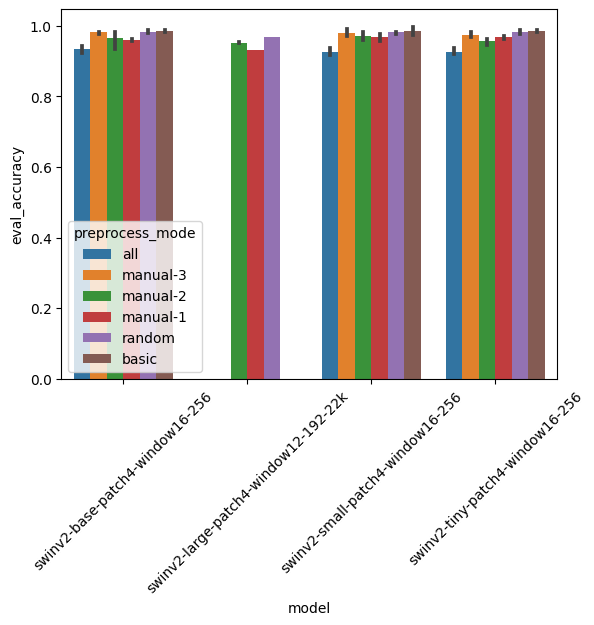

In [12]:
sns.barplot(df,x='model', y='eval_accuracy', hue='preprocess_mode')
plt.xticks(rotation=45)
plt.savefig('results.png')

### Test Results Analysis

In [23]:
def process_test_logs(fname):
    payload = ""
    data = []
    with open(fname, "r") as f:
        payload = f.read()

    for perf in re.findall(
        "checkpoint: (.*/checkpoint-\d+) acc: (\d\.\d+) prec: (\d\.\d+) rec: (\d\.\d+) f1: (\d\.\d+)",
        payload,
    ):
        model, performance_mode, dataset = (
            perf[0].split("/results_paper/")[1].split("/checkpoint")[0].split("_")
        )
        data.append(
            {
                "model": model,
                "preprocess_mode": performance_mode,
                "dataset": dataset,
                "test_acc": float(perf[1]),
                "test_prec": float(perf[2]),
                "test_rec": float(perf[3]),
                "test_f1": float(perf[4]),
            }
        )
    # performances = [{'model': perf[0].split('/results_paper/')[1].split('/checkpoint')[0].split('_'), 'test_acc': float(perf[1]), 'test_prec': float(perf[2]), 'test_rec': float(perf[3]), 'test_f1': float(perf[4])} ]
    return data

In [26]:
df = pd.DataFrame(process_test_logs("./perf_test.logs"))
df[:5]

,model,preprocess_mode,dataset,test_acc,test_prec,test_rec,test_f1
0,swinv2-base-patch4-window16-256,all,lab+maria,0.743750,0.777952,0.743750,0.711543
1,swinv2-base-patch4-window16-256,manual-3,lab+maria,0.700000,0.692500,0.700000,0.664997
2,swinv2-base-patch4-window16-256,manual-2,lab+maria,0.671875,0.685011,0.671875,0.641260
3,swinv2-base-patch4-window16-256,manual-1,lab+maria,0.656250,0.661411,0.656250,0.613353
4,swinv2-base-patch4-window16-256,random,lab+maria,0.631250,0.659531,0.631250,0.594550


In [27]:
max_acc_rows = df.groupby(["model", "preprocess_mode"])["test_acc"].idxmax()
df.loc[max_acc_rows]

,model,preprocess_mode,dataset,test_acc,test_prec,test_rec,test_f1
6,swinv2-base-patch4-window16-256,all,lab+pasi,0.7950,0.839236,0.7950,0.767389
11,swinv2-base-patch4-window16-256,basic,lab+pasi,0.7825,0.842084,0.7825,0.765571
9,swinv2-base-patch4-window16-256,manual-1,lab+pasi,0.8025,0.846665,0.8025,0.796293
8,swinv2-base-patch4-window16-256,manual-2,lab+pasi,0.7075,0.777799,0.7075,0.657704
7,swinv2-base-patch4-window16-256,manual-3,lab+pasi,0.8325,0.878171,0.8325,0.820845
10,swinv2-base-patch4-window16-256,random,lab+pasi,0.7400,0.793735,0.7400,0.719846
22,swinv2-large-patch4-window12-192-22k,manual-1,lab+pasi,0.7650,0.787219,0.7650,0.723954
21,swinv2-large-patch4-window12-192-22k,manual-2,lab+pasi,0.7575,0.817594,0.7575,0.712018
23,swinv2-large-patch4-window12-192-22k,random,lab+pasi,0.7950,0.849810,0.7950,0.782071
30,swinv2-small-patch4-window16-256,all,lab+pasi,0.7575,0.820152,0.7575,0.749397


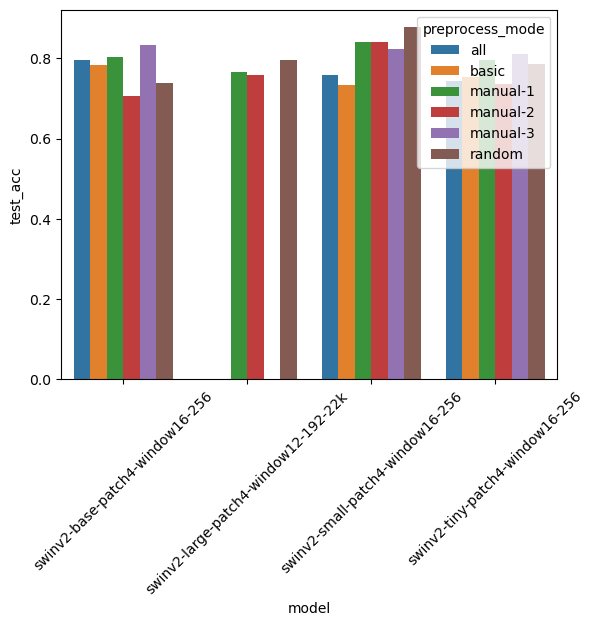

In [28]:
sns.barplot(df.loc[max_acc_rows], x="model", y="test_acc", hue="preprocess_mode")
plt.xticks(rotation=45)

In [29]:
max_acc_rows = df.groupby(["model", "dataset"])["test_acc"].idxmax()
df.loc[max_acc_rows]

,model,preprocess_mode,dataset,test_acc,test_prec,test_rec,test_f1
16,swinv2-base-patch4-window16-256,random,lab,0.583333,0.597765,0.583333,0.532126
0,swinv2-base-patch4-window16-256,all,lab+maria,0.743750,0.777952,0.743750,0.711543
7,swinv2-base-patch4-window16-256,manual-3,lab+pasi,0.832500,0.878171,0.832500,0.820845
18,swinv2-large-patch4-window12-192-22k,manual-2,lab,0.572222,0.634805,0.572222,0.541793
23,swinv2-large-patch4-window12-192-22k,random,lab+pasi,0.795000,0.849810,0.795000,0.782071
38,swinv2-small-patch4-window16-256,manual-2,lab,0.627778,0.697485,0.627778,0.604115
26,swinv2-small-patch4-window16-256,manual-2,lab+maria,0.718750,0.687883,0.718750,0.688031
34,swinv2-small-patch4-window16-256,random,lab+pasi,0.877500,0.899073,0.877500,0.866227
57,swinv2-tiny-patch4-window16-256,manual-1,lab,0.472222,0.563202,0.472222,0.436364
45,swinv2-tiny-patch4-window16-256,manual-1,lab+maria,0.631250,0.649074,0.631250,0.593577


(array([0, 1, 2, 3]),
 [Text(0, 0, 'swinv2-base-patch4-window16-256'),
  Text(1, 0, 'swinv2-large-patch4-window12-192-22k'),
  Text(2, 0, 'swinv2-small-patch4-window16-256'),
  Text(3, 0, 'swinv2-tiny-patch4-window16-256')])

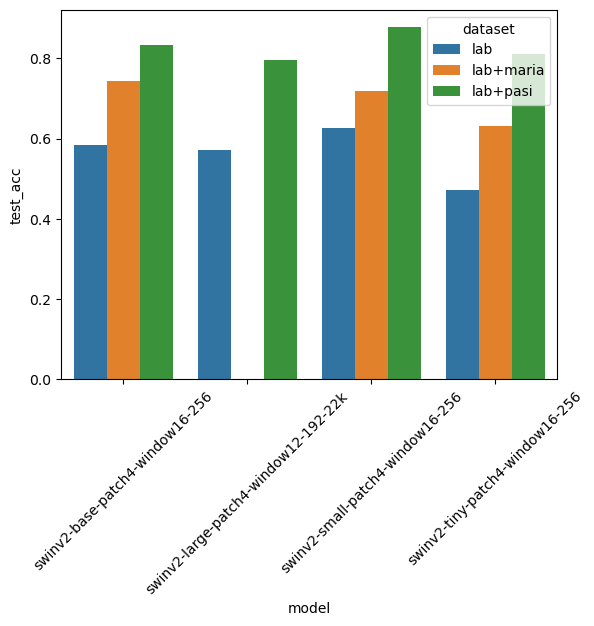

In [30]:
sns.barplot(df.loc[max_acc_rows], x="model", y="test_acc", hue="dataset")
plt.xticks(rotation=45)

In [31]:
max_acc_rows = df.groupby(["preprocess_mode", "dataset"])["test_acc"].idxmax()
df.loc[max_acc_rows]

,model,preprocess_mode,dataset,test_acc,test_prec,test_rec,test_f1
36,swinv2-small-patch4-window16-256,all,lab,0.559722,0.596871,0.559722,0.519156
0,swinv2-base-patch4-window16-256,all,lab+maria,0.743750,0.777952,0.743750,0.711543
6,swinv2-base-patch4-window16-256,all,lab+pasi,0.795000,0.839236,0.795000,0.767389
41,swinv2-small-patch4-window16-256,basic,lab,0.405556,0.608672,0.405556,0.395741
47,swinv2-tiny-patch4-window16-256,basic,lab+maria,0.609375,0.635656,0.609375,0.597642
11,swinv2-base-patch4-window16-256,basic,lab+pasi,0.782500,0.842084,0.782500,0.765571
19,swinv2-large-patch4-window12-192-22k,manual-1,lab,0.488889,0.645986,0.488889,0.447153
3,swinv2-base-patch4-window16-256,manual-1,lab+maria,0.656250,0.661411,0.656250,0.613353
33,swinv2-small-patch4-window16-256,manual-1,lab+pasi,0.840000,0.878524,0.840000,0.825439
38,swinv2-small-patch4-window16-256,manual-2,lab,0.627778,0.697485,0.627778,0.604115


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'all'),
  Text(1, 0, 'basic'),
  Text(2, 0, 'manual-1'),
  Text(3, 0, 'manual-2'),
  Text(4, 0, 'manual-3'),
  Text(5, 0, 'random')])

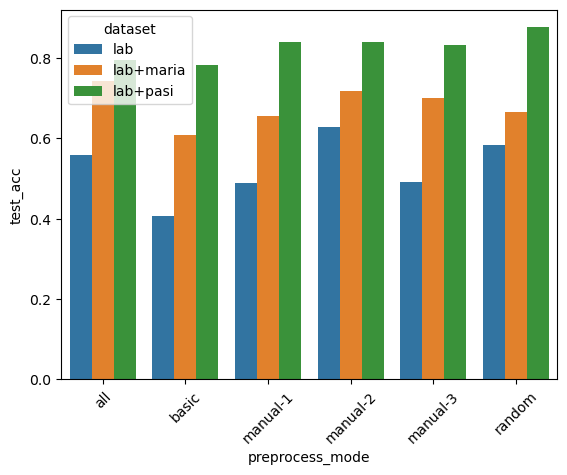

In [32]:
sns.barplot(df.loc[max_acc_rows], x="preprocess_mode", y="test_acc", hue="dataset")
plt.xticks(rotation=45)

In [33]:
max_acc_rows = df.groupby(["dataset", "preprocess_mode"])["test_acc"].idxmax()
df.loc[max_acc_rows]

,model,preprocess_mode,dataset,test_acc,test_prec,test_rec,test_f1
36,swinv2-small-patch4-window16-256,all,lab,0.559722,0.596871,0.559722,0.519156
41,swinv2-small-patch4-window16-256,basic,lab,0.405556,0.608672,0.405556,0.395741
19,swinv2-large-patch4-window12-192-22k,manual-1,lab,0.488889,0.645986,0.488889,0.447153
38,swinv2-small-patch4-window16-256,manual-2,lab,0.627778,0.697485,0.627778,0.604115
13,swinv2-base-patch4-window16-256,manual-3,lab,0.490278,0.544983,0.490278,0.463175
16,swinv2-base-patch4-window16-256,random,lab,0.583333,0.597765,0.583333,0.532126
0,swinv2-base-patch4-window16-256,all,lab+maria,0.743750,0.777952,0.743750,0.711543
47,swinv2-tiny-patch4-window16-256,basic,lab+maria,0.609375,0.635656,0.609375,0.597642
3,swinv2-base-patch4-window16-256,manual-1,lab+maria,0.656250,0.661411,0.656250,0.613353
26,swinv2-small-patch4-window16-256,manual-2,lab+maria,0.718750,0.687883,0.718750,0.688031


(array([0, 1, 2]),
 [Text(0, 0, 'lab'), Text(1, 0, 'lab+maria'), Text(2, 0, 'lab+pasi')])

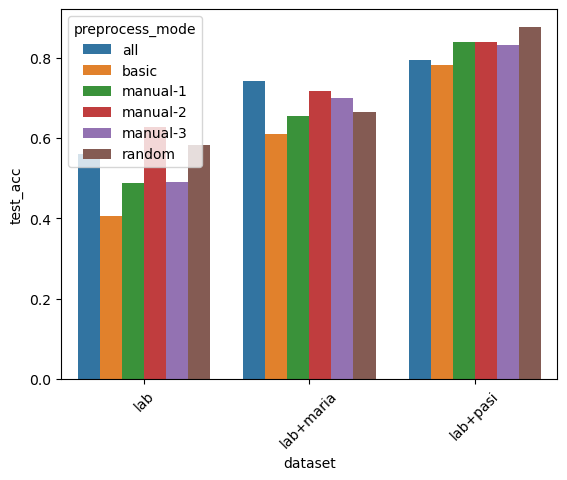

In [34]:
sns.barplot(df.loc[max_acc_rows], x="dataset", y="test_acc", hue="preprocess_mode")
plt.xticks(rotation=45)

In [35]:
df.to_csv("test.csv")